In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import scipy.fftpack
import scipy as sp
%matplotlib inline
sns.set()
pd.options.mode.use_inf_as_na = True

In [288]:
df = pd.read_csv('clean.csv',parse_dates=['date'])
df.head()

,Unnamed: 0,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name
0,0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,ahmadnagar
1,1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01,ahmadnagar
2,2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01,ahmadnagar
3,3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01,ahmadnagar
4,4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01,ahmadnagar


In [289]:
df.drop(['Unnamed: 0','district_name'],axis=1,inplace=True)
df.head()


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01
1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01
2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01
3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01
4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01


### First, we will get see how the mean of modal price changes with time by finding mean of all the commodities (individually, across all APMC) for each month. 
### <font color=red> Note: Taking a leap of faith that all the APMCs suffer the same price changes due to various factors e.g. 'drought'</font>

In [290]:
trendline = pd.pivot_table(df,index='Commodity',columns=['date'],aggfunc='mean')

In [291]:
trendline['modal_price'].head()

date,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,...,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00
Commodity,,,,,,,,,,,,,,,,,,,,,
amba koy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,3750.0,4750.000000,NaN,NaN,NaN,NaN
ambat chuka,0.000000,136.000000,167.000000,270.000000,0.0,0.0,0.0,196.0,0.0,1350.0,...,0.000000,NaN,193.000000,0.000000,500.0,325.500000,919.25,665.500000,748.000000,1251.0
amla,1400.000000,1777.000000,1580.000000,1634.000000,1637.5,1800.0,1800.0,NaN,NaN,NaN,...,1275.000000,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,1700.000000,1500.0
apple,6342.666667,5922.571429,6042.833333,5164.833333,5544.0,5137.0,6233.6,8497.0,10089.0,10161.0,...,6312.333333,8293.6,9961.444444,8427.181818,10037.2,8936.181818,7276.00,7290.461538,6615.083333,6905.6
arvi,2520.500000,2397.500000,2521.000000,2266.500000,2800.0,2622.5,2313.5,2405.5,2149.0,2207.5,...,1885.000000,2135.0,2371.500000,2484.333333,2434.5,2425.000000,2267.00,2043.000000,2006.500000,2010.5


###  Example to use the trendline pivot table to get monthly trendline for any commodity
trendline['feature_name'].loc['commodity_name'].plot()

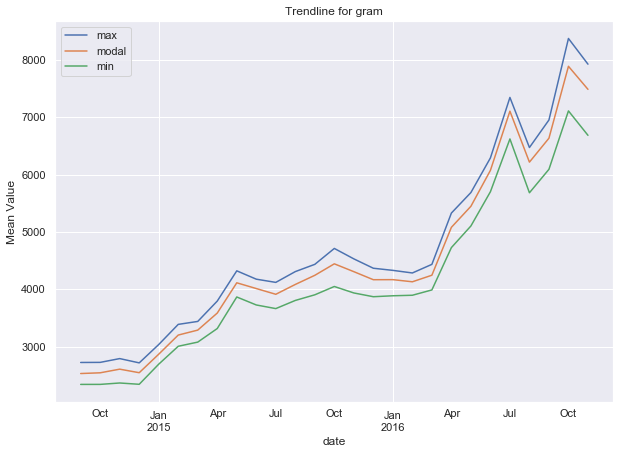

In [292]:
plt.figure(figsize=(10,7))
trendline['max_price'].loc['gram'].plot()
trendline['modal_price'].loc['gram'].plot()
trendline['min_price'].loc['gram'].plot()
plt.title('Trendline for gram')
plt.ylabel('Mean Value')
plt.legend(['max','modal','min'])

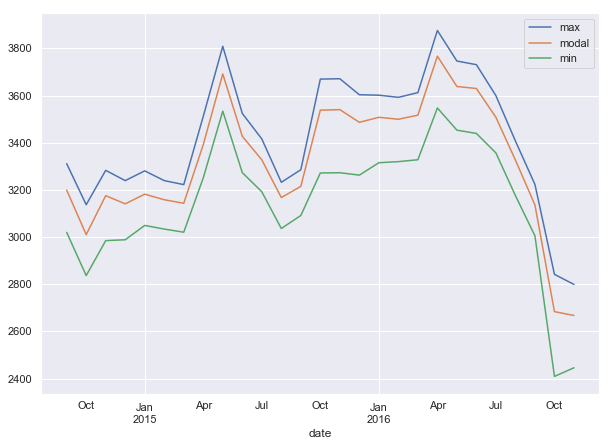

In [293]:
plt.figure(figsize=(10,7))
trendline['max_price'].loc['soybean'].plot()
trendline['modal_price'].loc['soybean'].plot()
trendline['min_price'].loc['soybean'].plot()
plt.legend(['max','modal','min'])

### The above two plots show that a generalization cannot be made about the trend for different commodity
### Mean values generated in the previous stage will be used to remove trend from the data.
### $f(t) = trend(t)*seasonal(t)* other \,components (t)$

In [294]:
monthly_data = df.groupby(['date', 'Commodity'])['modal_price'].mean().reset_index(name='Monthly Average')
std_data = df.groupby(['date', 'Commodity'])['modal_price'].std().reset_index(name='Monthly Std')

In [295]:
new_df = df.merge(monthly_data,on=['date','Commodity'])
new_df = new_df.merge(std_data,on=['date','Commodity'])

In [296]:
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.835821,209.379863
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.835821,209.379863
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.835821,209.379863
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.835821,209.379863
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.835821,209.379863


In [297]:
gram = new_df[new_df['Commodity']=='gram']
gram.sort_values(by='date',inplace=True)
type(gram)

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pandas.core.frame.DataFrame

Text(0.5, 0, 'Date')

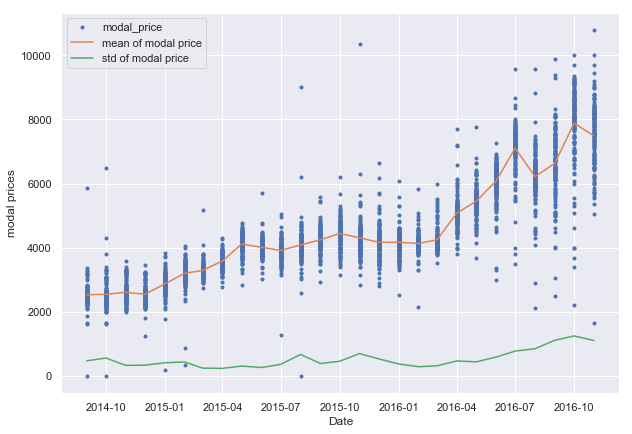

In [298]:
plt.figure(figsize=(10,7))
plt.plot(gram['date'],gram['modal_price'],'.')
plt.plot(gram['date'],gram['Monthly Average'],'-')
plt.plot(gram['date'],gram['Monthly Std'])
plt.legend(['modal_price','mean of modal price','std of modal price'])
plt.ylabel('modal prices')
plt.xlabel('Date')

In [299]:
new_df['fluctuation'] = new_df['modal_price']/new_df['Monthly Average']

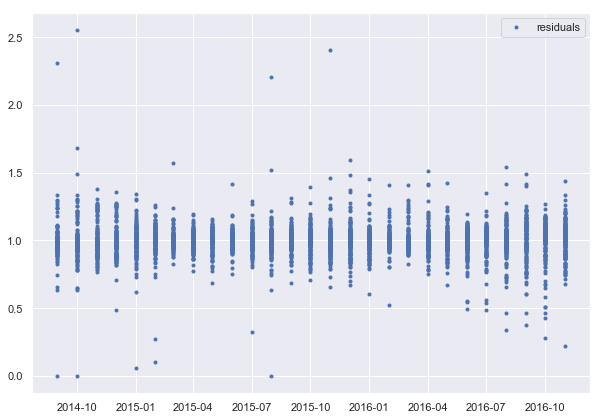

In [300]:
plt.figure(figsize=(10,7))
plt.plot(new_df[new_df['Commodity']=='gram']['date'],new_df[new_df['Commodity']=='gram']['fluctuation'],'.')
plt.legend(['residuals'])

### The above process helped to remove the trend and have a zero mean. 
### Re-assessing the mean and standard deviation after trend removal

In [301]:
fluctuation_mean = new_df.groupby(['date', 'Commodity'])['fluctuation'].mean().reset_index(name='Fluctuation_Mean')
fluctuation_std = new_df.groupby(['date', 'Commodity'])['fluctuation'].std().reset_index(name='Fluctuation_Std')

In [302]:
new_df = new_df.merge(fluctuation_mean,on=['date','Commodity'])
new_df = new_df.merge(fluctuation_std,on=['date','Commodity'])

In [303]:
new_df.sort_values(by='date')
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std,fluctuation,Fluctuation_Mean,Fluctuation_Std
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.835821,209.379863,1.067232,1.0,0.152739
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.835821,209.379863,1.112460,1.0,0.152739
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.835821,209.379863,1.003038,1.0,0.152739
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.835821,209.379863,1.022004,1.0,0.152739
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.835821,209.379863,0.938114,1.0,0.152739


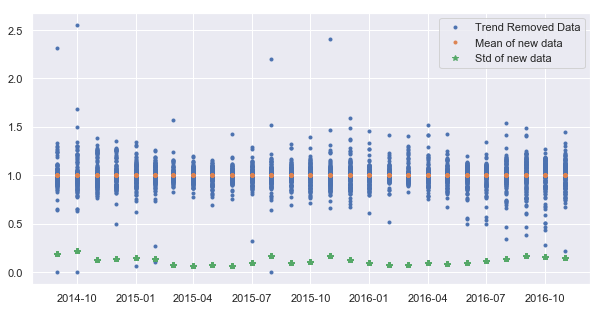

In [304]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['fluctuation'],'.')
plt.plot(gram['date'],gram['Fluctuation_Mean'],'.',linewidth=10)
plt.plot(gram['date'],gram['Fluctuation_Std'],'*',linewidth=20)
plt.legend(['Trend Removed Data','Mean of new data','Std of new data'])

### The above plot shows that the data is scattered around zero. thus, removal of trend seems to be fine.
### Additive model didnt have any effect on the standard deviation. Let's see if multiplicative model is able to make standard deviation invariant with time

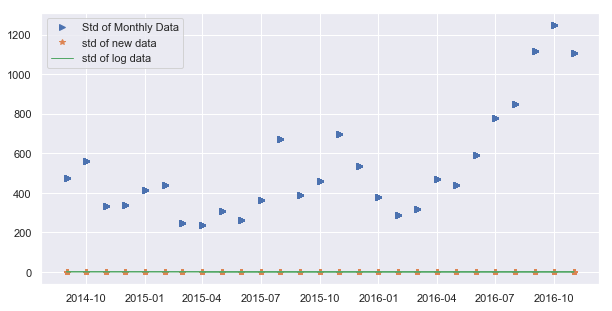

In [305]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['Monthly Std'],'>')
plt.plot(gram['date'],gram['Fluctuation_Std'],'*',linewidth=30)
plt.plot(gram['date'],gram['Fluctuation_Mean'],'-',linewidth=1)
plt.legend(['Std of Monthly Data','std of new data','std of log data'])

### Winner Winner Chicken Dinner!! :D :D
### The mean and standard deviation of the transformed data i.e. $R(t)=f(t)/(trend(t)*seasonal(t)$ seems to be reduced to an invariant quantity. 
### Sanity Check: Looking at periodogram to check the periodic elements present in the data and adfuller test to substantiate that the stationarity has been achieved


In [306]:
def periodogram(dataset,series_name,commodity_name,x_min=0,x_max=2.0):
    series = np.array(dataset[dataset['Commodity']==commodity_name][series_name])**2
    price_fft = sp.fftpack.fft(series)
    price_psd = np.abs(price_fft) ** 2
    fftfreq = sp.fftpack.fftfreq(len(price_psd),1/365)
    time_ = 1/fftfreq
    i = fftfreq > 0
    plt.figure(figsize=(10,7))
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(time_[i], price_psd[i])
    plt.xlim(x_min,x_max)
    ax.set_xlabel('Time Period (year)')
    ax.set_ylabel('Power Spectral Density')
    plt.legend([commodity_name])

### Below are some spectrum to judge the performance of the method used above to remove non-stationarity. 
### This is later reflected upon in the adfuller stats

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


<Figure size 720x504 with 0 Axes>

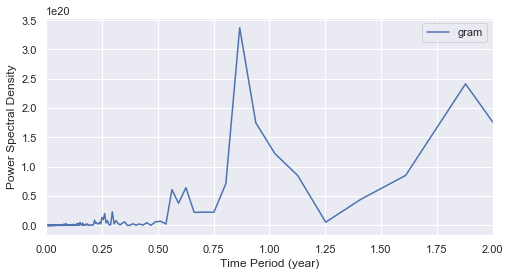

<Figure size 720x504 with 0 Axes>

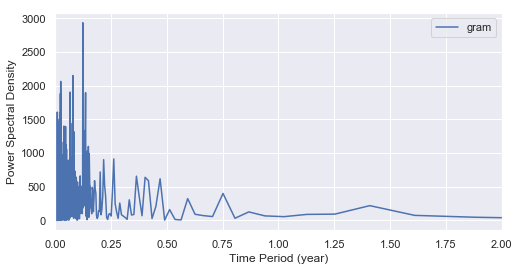

<Figure size 720x504 with 0 Axes>

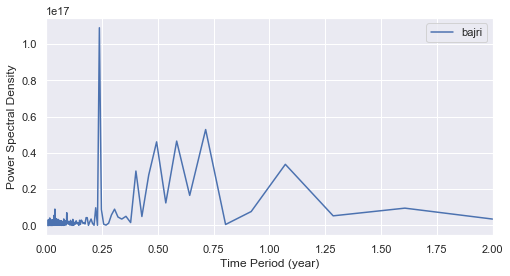

<Figure size 720x504 with 0 Axes>

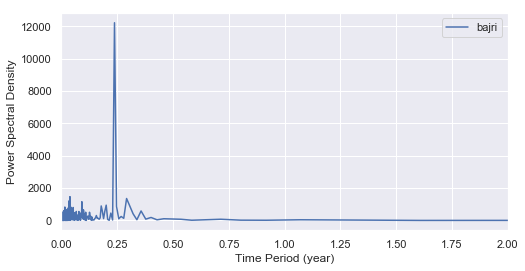

<Figure size 720x504 with 0 Axes>

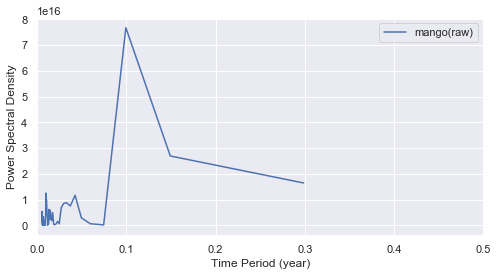

<Figure size 720x504 with 0 Axes>

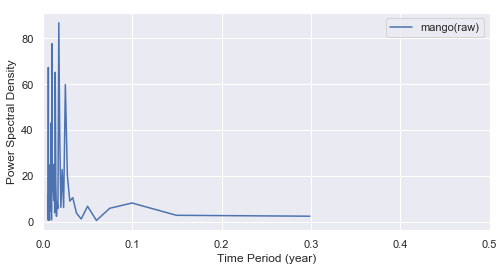

In [307]:
periodogram(new_df,'modal_price','gram')
periodogram(new_df,'fluctuation','gram')
periodogram(new_df,'modal_price','bajri')
periodogram(new_df,'fluctuation','bajri')
periodogram(new_df,'modal_price','mango(raw)',0,.5)
periodogram(new_df,'fluctuation','mango(raw)',0,0.5)

### Periodogram suggests that the periodic elements have been suppressed by a factor $>10^{15}$. This makes me feel confident about the multiplicative behavior of the price variation
### In order to keep everything same (except the model), all the processes have been repeated in exactly the same manner. Again, maxlag will be used to remove the commodities with insufficient number of datapoints. Remaining will be tested with adfuller

In [308]:
def maxlag(x): return int(12.0*pow((len(x)/100.0),0.25))

In [309]:
relevant_data = new_df[['Commodity','modal_price','fluctuation']]
commodity     = np.array(pd.pivot_table(new_df,index='Commodity').index)

In [310]:
print ('old shape: ',new_df.shape)
for i in range(0,len(commodity)):
    series = new_df[new_df['Commodity']==commodity[i]]['modal_price']
    if (maxlag(series)<12):
        indexes = new_df[new_df['Commodity']==commodity[i]].index
        new_df.drop(indexes,inplace=True,axis=0)

commodity = np.array(pd.pivot_table(new_df,index='Commodity').index)
print ('new shape: ',new_df.shape)

old shape:  (62418, 14)
new shape:  (59696, 14)


### Define the hypothesis to test the generated data for seasonality and trend
### Null Hypothesis: The data 'modal_prices' contains seasonality and trend
### Alternate Hypothesis: The data 'modal prices' doesnt contain any seasonality or trend

In [311]:
from statsmodels.tsa.stattools import adfuller
def adf(x):
    result = adfuller(x)
    adf_stat = result[0]
    p_value  = result[1]
    cv_1     = result[4].get('1%')
    cv_5     = result[4].get('5%')
    cv_10    = result[4].get('10%')
    return [adf_stat,p_value,cv_1,cv_5,cv_10]

In [312]:
### defining a function to perform adfuller test on a series (defined by series_name) contained within (dataframe)
### for a list of commodity of interest.
def test_adf(dataframe,series_name,commodity):
    name=[]
    stationarity=[]
    adf_stats = []
    p_value = []
    cv_1 = []
    cv_5 = []
    cv_10 = []
    for i in range(0,len(commodity)):
        series = np.array(dataframe[dataframe['Commodity']==str(commodity[i])][series_name])
        name.append(commodity[i])
        result = adf(series)
        adf_stats.append(result[0])
        p_value.append(result[1])
        cv_1.append(result[2])
        cv_5.append(result[3])
        cv_10.append(result[4])
        test_stas = pd.DataFrame({'name':name,'adf':adf_stats,'p_value':p_value,'critical value 1%':cv_1,'critical value 5%':cv_5,'critical value 10%':cv_10}) 
        test_stas.set_index('name',inplace=True)
    return test_stas

### Earlier, monthly average of 'modal_prices' was taken and then subtracted from the main dataset. 
### Below is the adfuller test to check the number of data points with a significance level of greater than 1% 

In [313]:
on_modal_price = test_adf(new_df,'modal_price',commodity)
on_monthly_averaged = test_adf(new_df,'fluctuation',commodity)

In [314]:
ind = on_modal_price['adf']>on_modal_price['critical value 1%']
on_modal_price[ind].head()

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,
bitter gourd,-3.402447,0.010876,-3.438439,-2.865110,-2.568671
cucumber,-3.196024,0.020216,-3.438379,-2.865084,-2.568657
ghosali(bhaji),-3.347651,0.012878,-3.464694,-2.876635,-2.574816
green chilli,-3.120525,0.025071,-3.438196,-2.865003,-2.568614
green peas (dry),-3.332980,0.013467,-3.460428,-2.874769,-2.573821


In [315]:
on_monthly_averaged[ind].head()

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,
bitter gourd,-10.333988,2.794777e-18,-3.438540,-2.865155,-2.568695
cucumber,-10.622867,5.458376e-19,-3.438350,-2.865071,-2.568650
ghosali(bhaji),-8.022693,2.056052e-12,-3.464875,-2.876714,-2.574859
green chilli,-9.704150,1.052815e-16,-3.438311,-2.865054,-2.568641
green peas (dry),-10.105386,1.033215e-17,-3.460154,-2.874649,-2.573757


In [316]:
on_monthly_averaged[on_monthly_averaged['adf']>on_monthly_averaged['critical value 1%']]

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,


### On comparing the adfuller test for both models, similar results have been obtained. This suggests that both the models were able to remove non-stationarity. <font color=red> However, for me a visual inspection of the standard deviation of the fluctuations and the spectral analysis suggests that the seasonality must be multiplicative.</font>
### The above test shows that there is less than 1% probability that removing the monthly average from the modal prices has not removed the trend and the seasonality from all the commodity data.

In [317]:
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std,fluctuation,Fluctuation_Mean,Fluctuation_Std
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.835821,209.379863,1.067232,1.0,0.152739
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.835821,209.379863,1.112460,1.0,0.152739
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.835821,209.379863,1.003038,1.0,0.152739
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.835821,209.379863,1.022004,1.0,0.152739
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.835821,209.379863,0.938114,1.0,0.152739


In [318]:
new_df.drop(['Monthly Std','Fluctuation_Mean','Fluctuation_Std','Monthly Average'],axis=1,inplace=True)

In [319]:
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,fluctuation
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1.067232
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1.112460
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1.003038
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1.022004
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,0.938114


In [320]:
new_df.to_csv('after_removing_multiplicative.csv')

### Above, a new file has been created which contains a new column ''fluctuation". This column contains detrended and deseasonalised data (residuals) and may be suitable for modelling purposes.


In [321]:
msp = pd.read_csv('CMO_MSP_Mandi.csv')

In [322]:
msp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
commodity     155 non-null object
year          155 non-null int64
Type          155 non-null object
msprice       145 non-null float64
msp_filter    155 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.1+ KB


In [323]:
msp['commodity']=msp['commodity'].str.lower()
msp['commodity']=msp['commodity'].str.replace('-',' ')
msp['commodity']=msp['commodity'].str.replace('_',' ')
msp['commodity']=msp['commodity'].str.replace('sugar cane','sugarcane')

In [324]:
msp['commodity'].value_counts()

maize                     5
wheat(husked)             5
mustard                   5
coconut                   5
spilt gerrn gram          5
sunflower                 5
gr.nut kernels            5
split black gram          5
copra (ball) yellow       5
copra (milling) yellow    5
paddy unhusked            5
ragi maldandi             5
safflower                 5
sugarcane                 5
bajri                     5
barli                     5
pigeon pea (tur)          5
gram yellow               5
rice(paddy hus)           5
sorgum(jawar)             5
niger seed                5
toria yellow              5
cotton long staple        5
jowar hybrid              5
sesamum                   5
soyabean                  5
soyabean black            5
cotton                    5
jute yellow               5
wheat(unhusked)           5
masur yellow              5
Name: commodity, dtype: int64

In [325]:
msp_table = pd.pivot_table(msp,index=['commodity','year'],values='msprice')

In [326]:
common_commodity = list(set(df['Commodity']).intersection(set(msp['commodity'])))

In [327]:
common_commodity

['mustard',
 'spilt gerrn gram',
 'maize',
 'gr.nut kernels',
 'sugarcane',
 'sunflower',
 'pigeon pea (tur)',
 'sesamum',
 'split black gram',
 'safflower',
 'cotton',
 'wheat(unhusked)',
 'coconut',
 'wheat(husked)',
 'bajri',
 'sorgum(jawar)']

### Using the trendline and then fitting with a line to get the overall trend i.e. upward or downward. A file may be generated with coeffcients (intercept and slope) so as to use later.

In [328]:
### Working on example commodity 'gram'
gh = trendline['max_price'].loc['gram']

Text(0, 0.5, 'price')

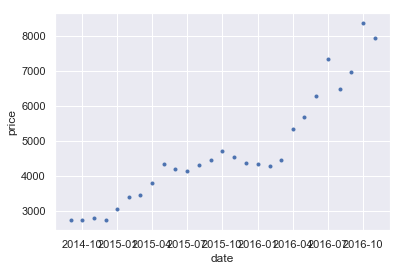

In [329]:
plt.plot(gh.index,np.array(gh),'.')
plt.xlabel('date')
plt.ylabel('price')

In [330]:
def f(x,a,m): return a+m*x

In [331]:
number_of_days=(max(gh.index)-min(gh.index)).days
days_data = np.arange(0,len(gh))
popt, pcov = scipy.optimize.curve_fit(f,days_data,np.array(gh))
popt,pcov

(array([2267.49819725,  187.54213644]),
 array([[50695.70421657, -2869.56818006],
        [-2869.56818006,   220.7360155 ]]))

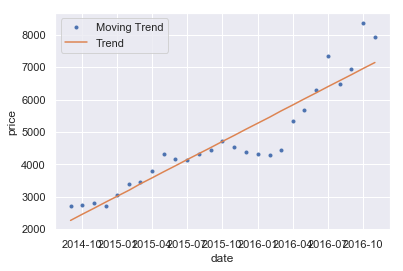

In [332]:
plt.plot(gh.index,np.array(gh),'.')
plt.plot(gh.index, f(days_data, *popt))
plt.xlabel('date')
plt.ylabel('price')
plt.legend(['Moving Trend','Trend'])

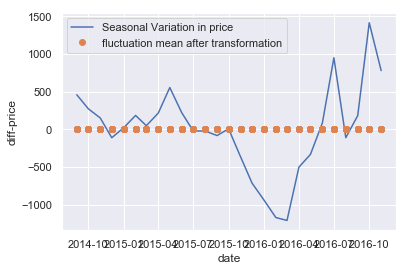

In [333]:
### Seasonal component
plt.plot(gh.index, gh-f(days_data, *popt))
plt.plot(gram['date'],gram['Fluctuation_Mean'],'o',linewidth=1)
plt.xlabel('date')
plt.ylabel('diff-price')
plt.legend(['Seasonal Variation in price','fluctuation mean after transformation'])

### Above simple model of trend seems to be doing fine in separating the overall trend and the seasonal variations.
### Generalising - steps : 
### 1. define a method to bring out the linear trend to figure out if the price is growing or falling
### 2. loop over all the crops to find the intercept, slope  and r squared value. 

In [334]:
def decompose_trend(trendline,series_name,commodity_name):
    gh = trendline[series_name].loc[commodity_name]
    gh.dropna(inplace=True)
    days_data = np.arange(0,len(gh))
    ydata = np.array(gh)
    xdata = days_data
    popt, pcov = scipy.optimize.curve_fit(f,xdata,ydata)
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return [popt[0],popt[1],r_squared]

In [335]:
trendline = pd.pivot_table(new_df,index='Commodity',columns=['date'],aggfunc='mean')
decompose_trend(trendline,'modal_price','mustard')

[3231.0374152482204, 19.10046454899233, 0.4433585441714062]

In [336]:
crops = new_df['Commodity'].value_counts().index.tolist()

In [340]:
intercept = []
slope     = []
r_score   = []
for i in range(0,len(crops)):
    results =  decompose_trend(trendline,'modal_price',crops[i])
    intercept.append(results[0])
    slope.append(results[1])
    r_score.append(results[2])

line_coeff = pd.DataFrame({'name':crops,'intercept':intercept,'slope':slope,'r2_score':r_score})

### A very interesting find follows - "<font color=red> The crops for which r squared value is very weak i.e. the price is not tending to increase or fall have dominant seasonal tendency, while the crops that show linear trend are usually year round crops" </font>

In [352]:
line_coeff[line_coeff['r2_score']<0.1].head()

,name,intercept,slope,r2_score
12,tomato,1243.855828,0.515945,0.000061
78,snake gourd,1486.232697,0.505415,0.000095
24,capsicum,2250.043050,-0.923579,0.000109
20,bitter gourd,2636.096442,1.438266,0.000211
23,rice(paddy-hus),2923.900542,-0.284478,0.000213


In [355]:
line_coeff[line_coeff['r2_score']>0.].tail()

,name,intercept,slope,r2_score
11,cotton,3845.765555,34.243058,0.658677
26,garlic,3155.683457,215.683050,0.682511
28,sesamum,8746.420459,-144.675002,0.777594
0,gram,2126.564854,181.081992,0.873810
1,wheat(husked),1525.592862,12.093352,0.919584


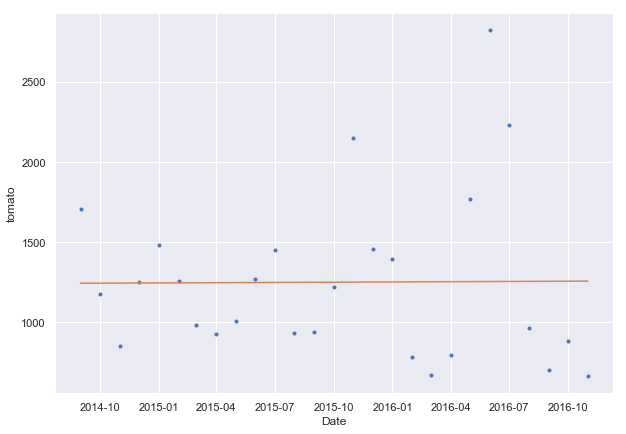

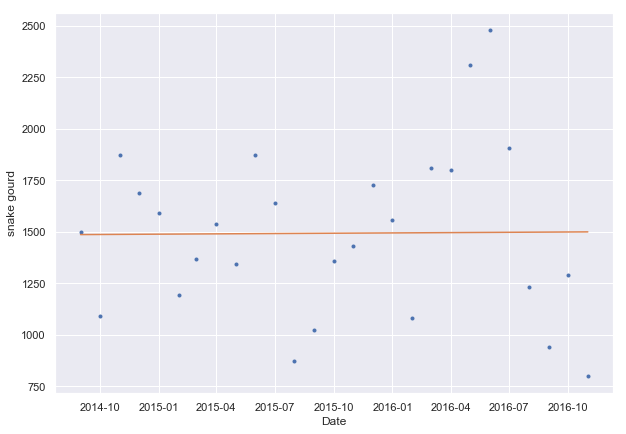

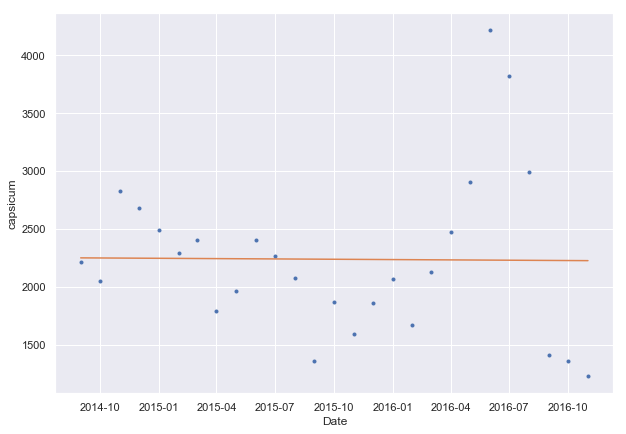

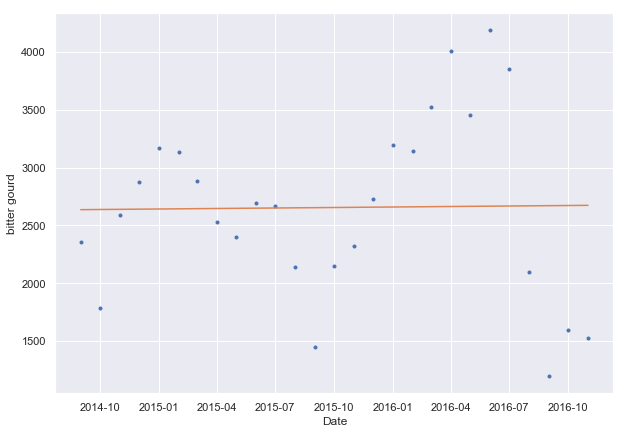

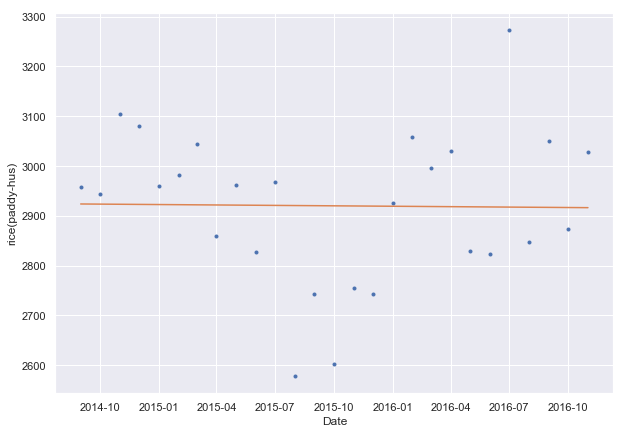

In [360]:
crop_name = ['tomato','snake gourd','capsicum','bitter gourd','rice(paddy-hus)']
for i in range(0,len(crop_name)):
    plt.figure(figsize=(10,7))
    dt = trendline['modal_price'].columns.tolist()
    y = trendline['modal_price'].loc[crop_name[i]]
    plt.plot(dt,y,'.')
    intercept,coeff,r2 = decompose_trend(trendline,'modal_price',crop_name[i])
    dt1 = np.arange(0,len(trendline['modal_price'].loc[crop_name[i]]))
    plt.plot(dt,f(dt1,intercept,coeff),'-')
    plt.xlabel('Date')
    plt.ylabel(crop_name[i])

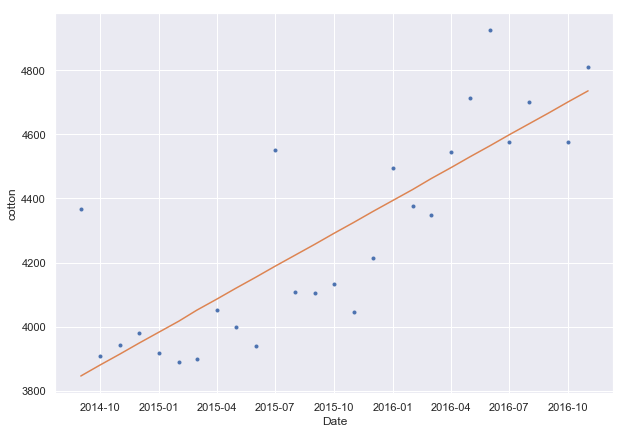

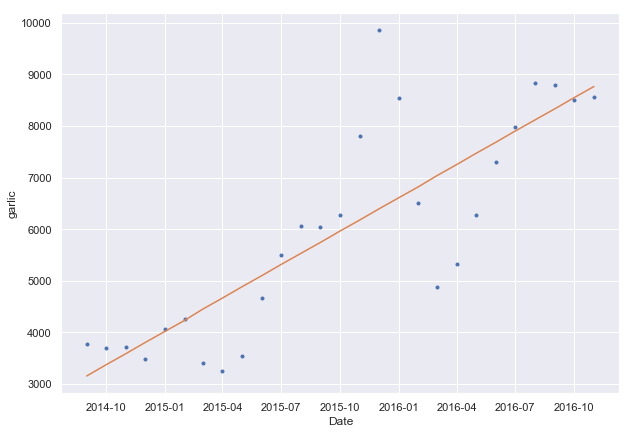

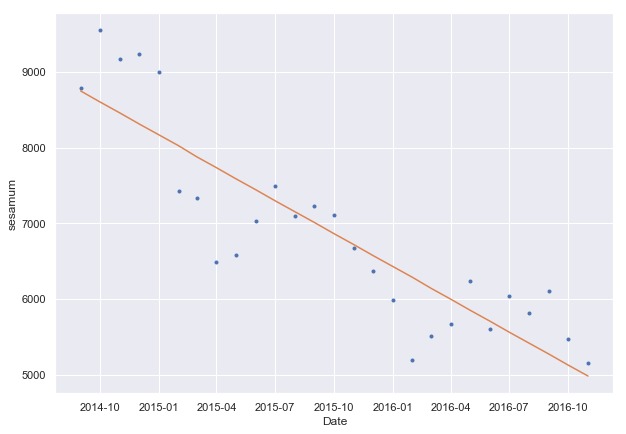

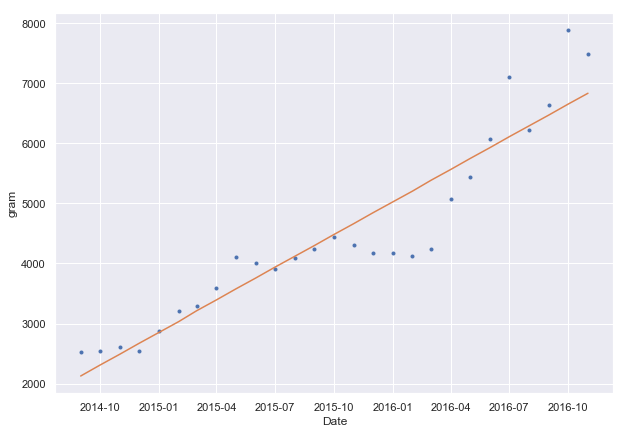

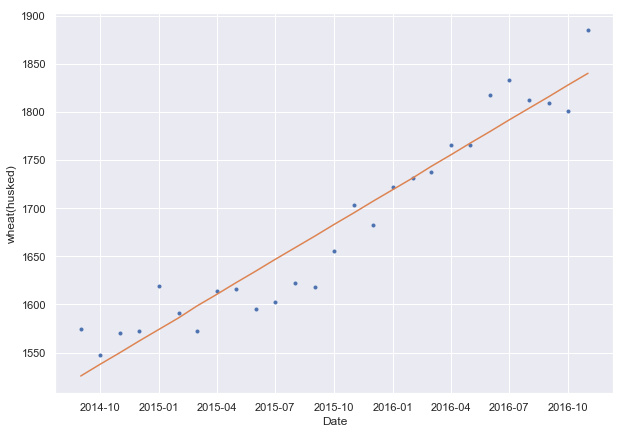

In [361]:
crop_name =[ 'cotton','garlic','sesamum','gram','wheat(husked)']
for i in range(0,len(crop_name)):
    plt.figure(figsize=(10,7))
    dt = trendline['modal_price'].columns.tolist()
    y = trendline['modal_price'].loc[crop_name[i]]
    plt.plot(dt,y,'.')
    intercept,coeff,r2 = decompose_trend(trendline,'modal_price',crop_name[i])
    dt1 = np.arange(0,len(trendline['modal_price'].loc[crop_name[i]]))
    plt.plot(dt,f(dt1,intercept,coeff),'-')
    plt.xlabel('Date')
    plt.ylabel(crop_name[i])

In [362]:
line_coeff.to_csv("trend_coefficients.csv")